# Conditional Generative Neural Networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Center-for-Health-Data-Science/IntroToML/blob/HEAD/Day3/scVAE-conditional.ipynb)

This is meant as a continuation of the scVAE notebook. Complete that first before continuing.

## Prerequisites

Import packages:

In [2]:
import scvae
import scanpy as sc
import anndata as ad
import tensorflow as tf

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Load data set:

In [3]:
lupus = sc.read("lupus.h5ad")
lupus

AnnData object with n_obs × n_vars = 3204 × 2525
    obs: 'library_uuid', 'cell_state', 'disease_state', 'donor_uuid', 'cell_type', 'disease', 'sex', 'ethnicity', 'development_stage', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'counts'

## Conditional VAE

scVAE also supports conditioning a model on (multiple) cell annotations present in the data set. Doing so, helps the model taking into account these annitations. They can be set along with the other hyperparameters:

In [4]:
FEATURE_SIZE = lupus.n_vars
HIDDEN_SIZES = [200, 200]
LATENT_SIZE = 50
LIKELIHOOD_NAME = "negative_binomial"
LEARNING_RATE = 1e-3
CONDITIONAL_ANNOTATION_NAMES = ["library_uuid"]

The conditional VAE is initialised, compiled, and trained:

In [5]:
cvae = scvae.models.VariationalAutoEncoder(
    original_dim=FEATURE_SIZE,
    intermediate_dims=HIDDEN_SIZES,
    latent_dim=LATENT_SIZE,
    likelihood_name=LIKELIHOOD_NAME,
    conditional_annotation_names=CONDITIONAL_ANNOTATION_NAMES)
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
cvae.compile(optimizer=optimiser)

2022-05-25 11:36:34.245864: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
cvae_history = cvae.fit(lupus, layer="counts", epochs=50)

Epoch 1/50


2022-05-25 11:36:56.746673: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


51/51 [==============================] - 3s 17ms/step - lower_bound: -898.5728 - reconstruction_error: -884.7798 - kl_divergence: 13.7929
Epoch 2/50
51/51 [==============================] - 1s 18ms/step - lower_bound: -525.1287 - reconstruction_error: -514.8712 - kl_divergence: 10.2575
Epoch 3/50
51/51 [==============================] - 1s 21ms/step - lower_bound: -500.9305 - reconstruction_error: -491.3221 - kl_divergence: 9.6083
Epoch 4/50
51/51 [==============================] - 1s 19ms/step - lower_bound: -491.9855 - reconstruction_error: -482.5715 - kl_divergence: 9.4140
Epoch 5/50
51/51 [==============================] - 1s 19ms/step - lower_bound: -493.4669 - reconstruction_error: -483.9932 - kl_divergence: 9.4737
Epoch 6/50
51/51 [==============================] - 1s 19ms/step - lower_bound: -490.3701 - reconstruction_error: -478.9503 - kl_divergence: 11.4198
Epoch 7/50
51/51 [==============================] - 1s 21ms/step - lower_bound: -484.8995 - reconstruction_error: -475.5

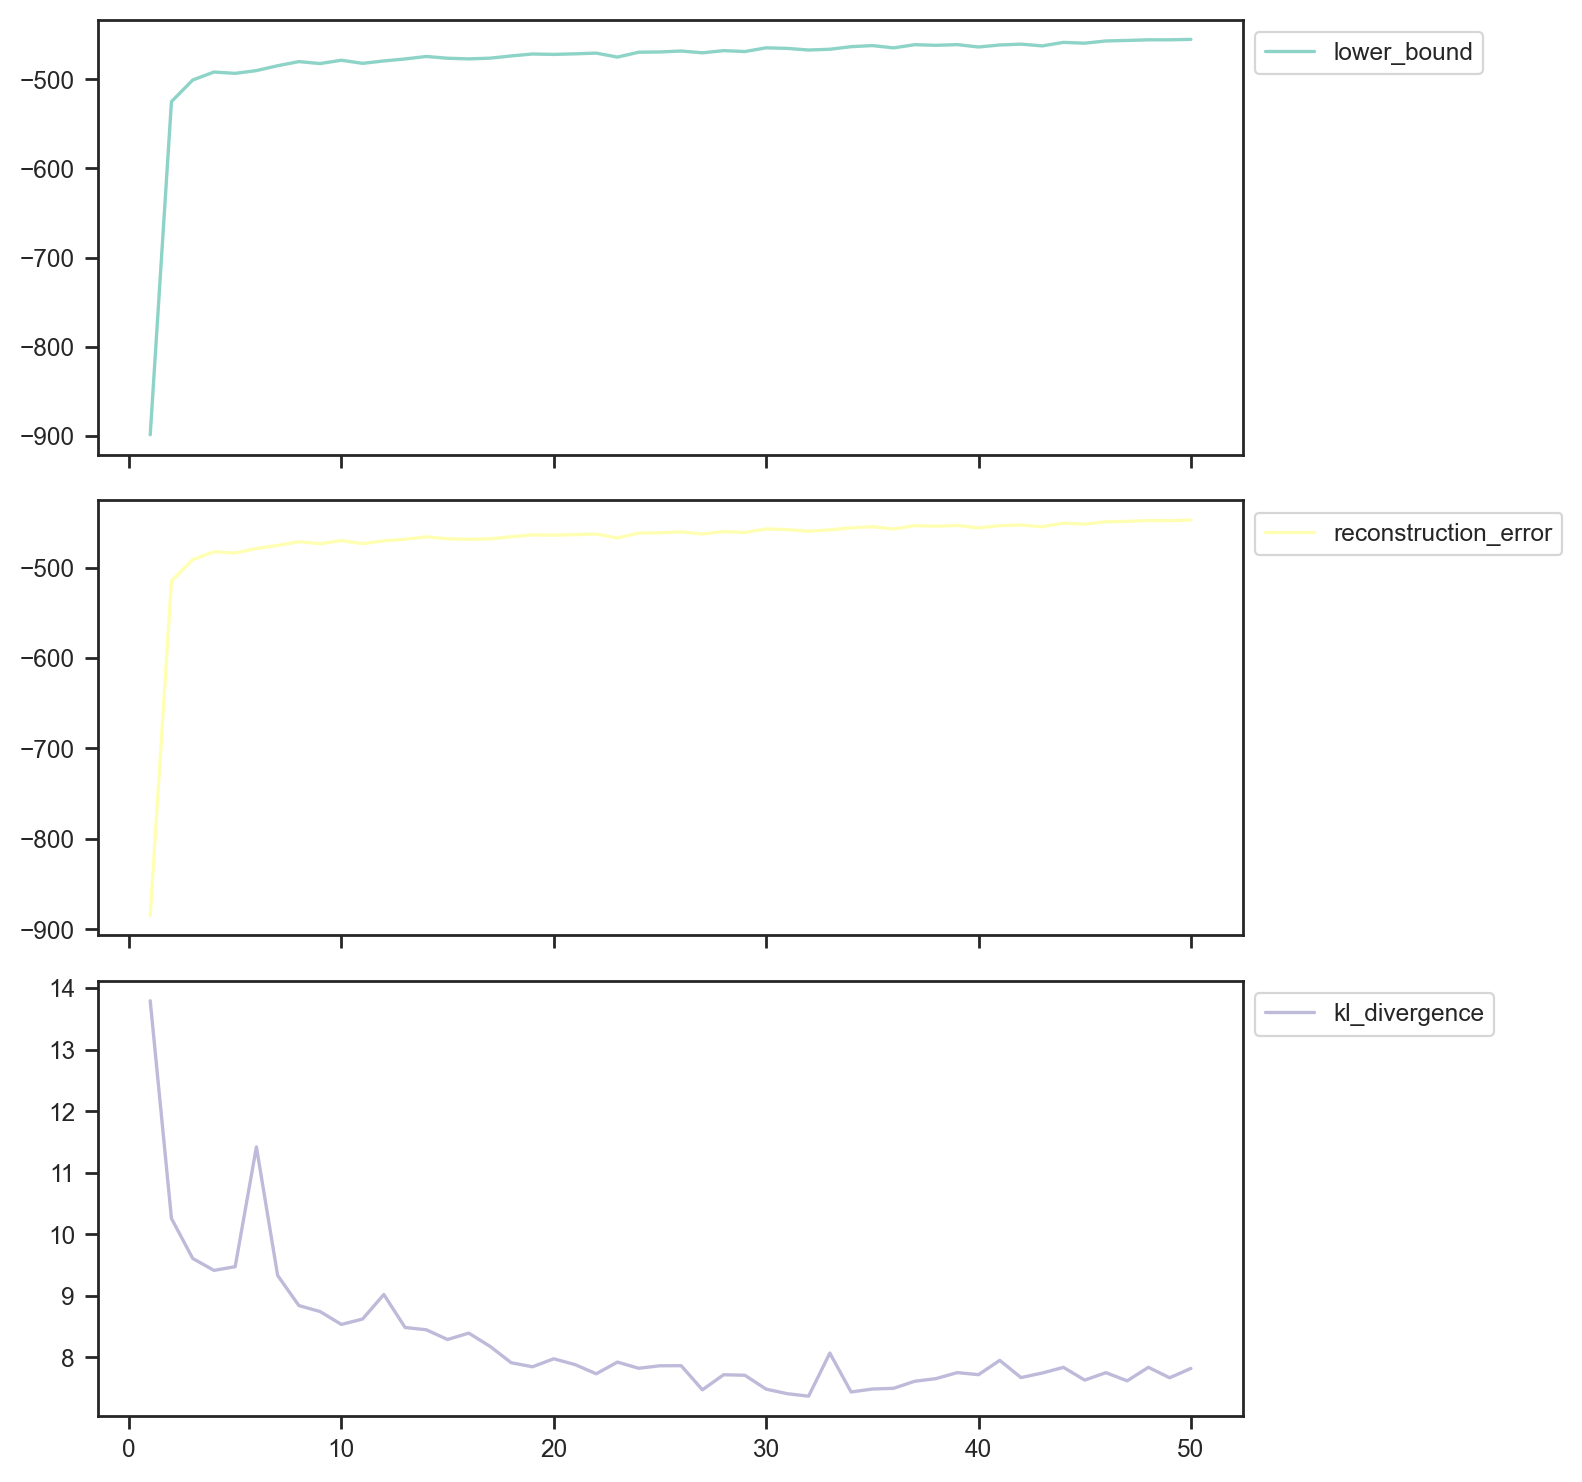

In [7]:
scvae.visualisation.plot_learning_curves(cvae_history)

Evaluate the conditional VAE model and visualise the latent representation:

In [8]:
cvae_evaluation = cvae.evaluate(lupus, layer="counts")

51/51 [==============================] - 1s 20ms/step - lower_bound: -451.2086 - reconstruction_error: -443.6125 - kl_divergence: 7.5961


In [9]:
cvae_latent_representation = ad.AnnData(
    cvae.encoder.predict(lupus, layer="counts"),
    obs=lupus.obs)

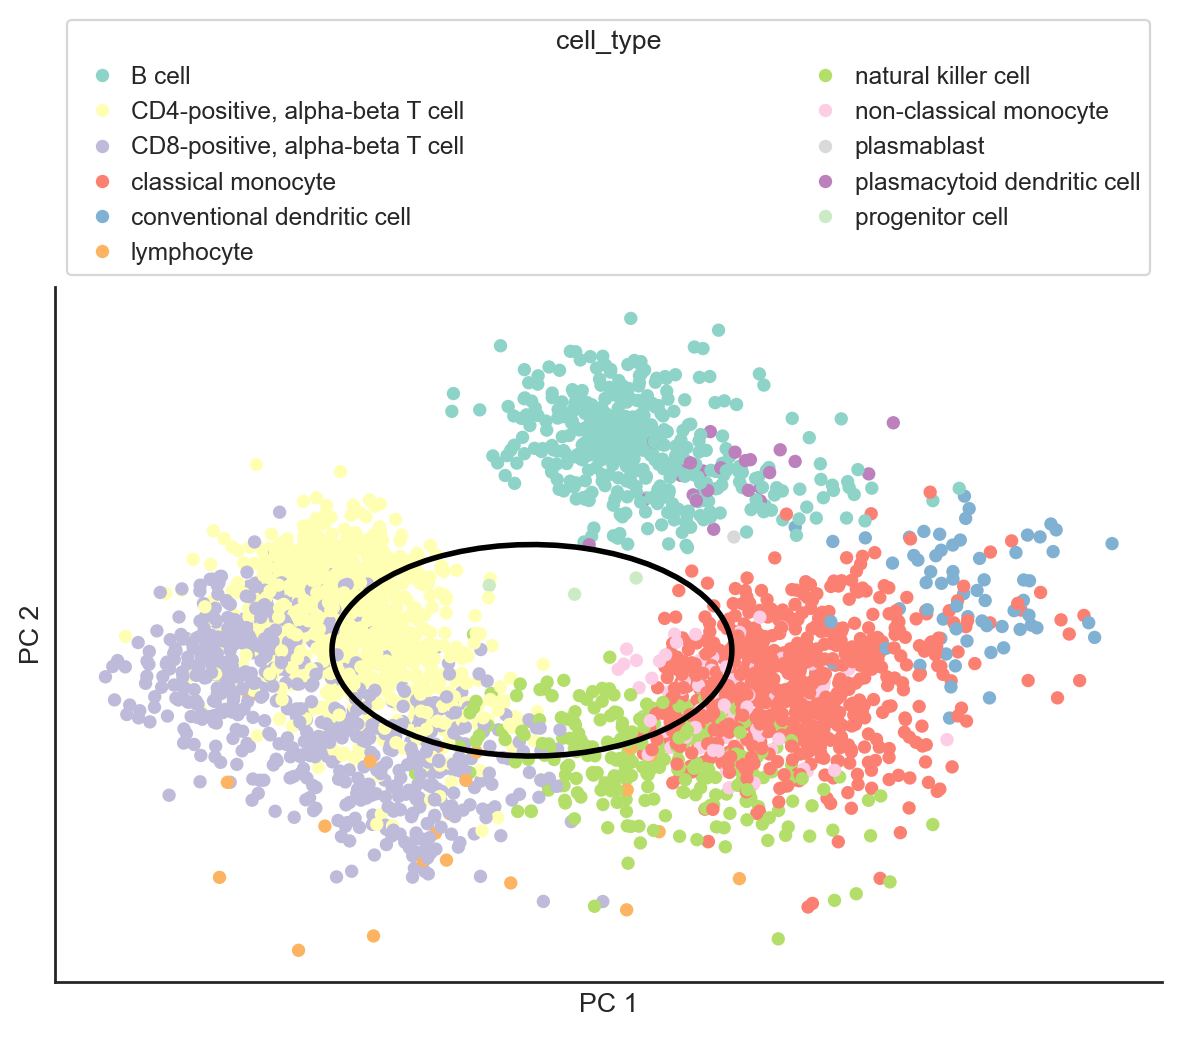

In [10]:
scvae.visualisation.plot_latent_representation(
    cvae_latent_representation, annotation_name="cell_type", model=cvae)

In [11]:
sc.pp.neighbors(cvae_latent_representation)
sc.tl.umap(cvae_latent_representation)

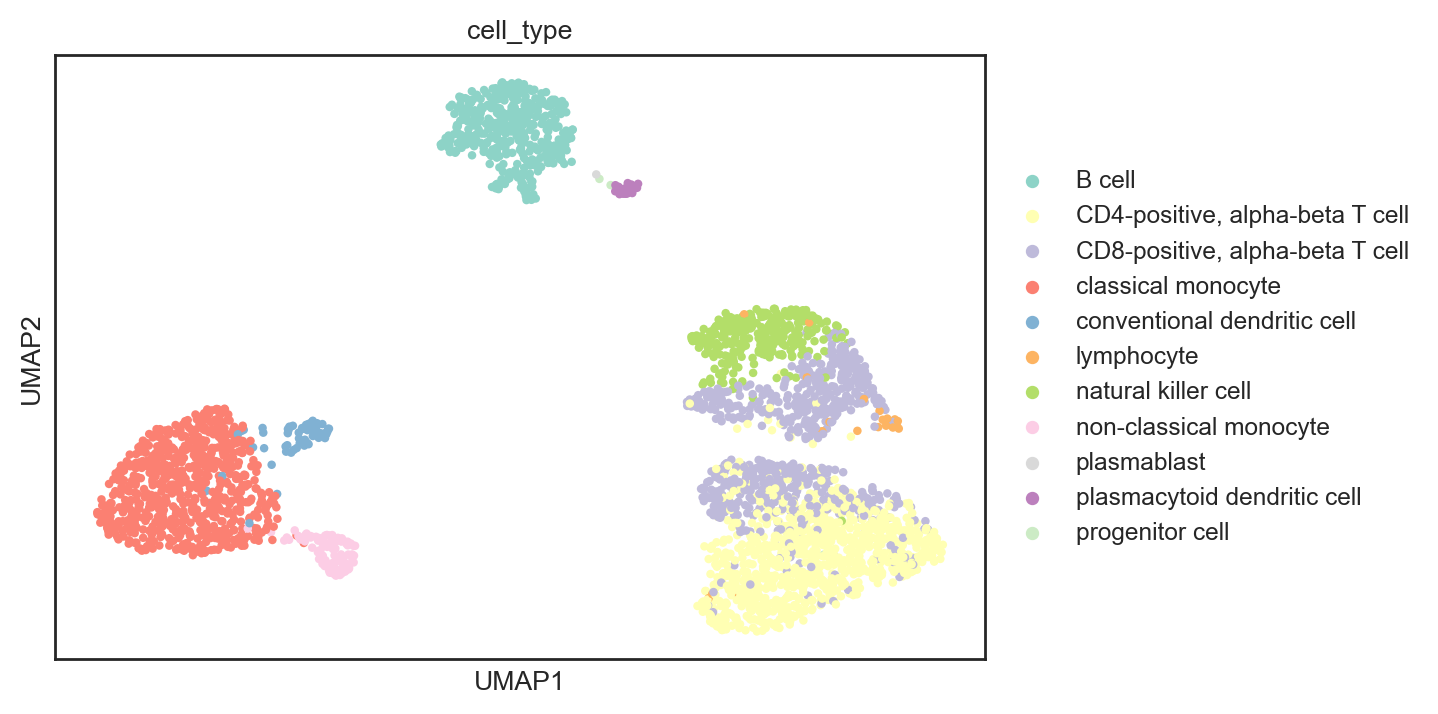

In [12]:
sc.pl.umap(cvae_latent_representation, color="cell_type")

### Exercises

* Try training the model conditioned on different annotations and compare the log-likelihood lower bounds. You can also condition multiple annotations.
* Compare the log-likelihood lower bound with the ones for the other VAE models. Does it improve?
* Compare with the PCA and UMAP plots of the original data set and the other latent representations. What is the effect of conditioning on different annotations?

## Conditional GMVAE

Hyperparameters:

In [13]:
COMPONENT_COUNT = 7
CONDITIONAL_ANNOTATION_NAMES = ["library_uuid"]

Initialise, compile, and train conditional GMVAE:

In [ ]:
cgmvae = scvae.models.VariationalAutoEncoder(
    original_dim=FEATURE_SIZE,
    intermediate_dims=HIDDEN_SIZES,
    latent_dim=LATENT_SIZE,
    likelihood_name=LIKELIHOOD_NAME,
    conditional_annotation_names=CONDITIONAL_ANNOTATION_NAMES,
    approximate_posterior_name="gaussian_mixture",
    prior_name="gaussian_mixture",
    mixture_component_size=COMPONENT_COUNT)
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
cgmvae.compile(optimizer=optimiser)

In [ ]:
cgmvae_history = cgmvae.fit(lupus, layer="counts", epochs=50)

In [ ]:
scvae.visualisation.plot_learning_curves(cgmvae_history)

Evaluate the conditional GMVAE model and visualise the latent representation:

In [ ]:
cgmvae_evaluation = cgmvae.evaluate(lupus, layer="counts")

In [ ]:
cgmvae_latent_values, cgmvae_latent_category_logits = cgmvae.encoder.predict(
    lupus, layer="counts")
cgmvae_latent_representation = ad.AnnData(
    cgmvae_latent_values,
    obs=lupus.obs)
cgmvae_latent_representation.obs["latent_category"] = (
    cgmvae_latent_category_logits.argmax(axis=-1))

In [ ]:
scvae.visualisation.plot_latent_representation(
    cgmvae_latent_representation, annotation_name="cell_type", model=cgmvae)

In [ ]:
sc.pp.neighbors(cgmvae_latent_representation)
sc.tl.umap(cgmvae_latent_representation)

In [ ]:
sc.pl.umap(cgmvae_latent_representation, color="cell_type")

### Exercises

* Try training the model conditioned on different annotations and compare the log-likelihood lower bounds. You can also condition multiple annotations.
* Compare the log-likelihood lower bound with the ones for the other VAE models. Does it improve?
* Compare with the PCA and UMAP plots of the original data set and the other latent representations. What is the effect of conditioning on different annotations?